In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.8 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZhKWCwI8rz9309wg03nk")
project = rf.workspace("andrea-marazzina").project("construction-ppe-rdhzo-fnopv")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.13.0.92
    Uninstalling opencv-python-headless-4.13.0.92:
      Successfully uninstalled opencv-python-headless-4.13.0.92
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-PPE-1 in yolov8:: 100%|██████████| 17702/17702 [00:03<00:00, 5448.19it/s]


In [ ]:
!ls

Construction-PPE-1  sample_data


In [ ]:
import yaml, pprint

with open("Construction-PPE-1/data.yaml", "r") as f:
    data = yaml.safe_load(f)

pprint.pprint(data)
print("\nClass names:")
for i, n in enumerate(data.get("names", [])):
    print(i, n)

{'names': ['Gloves',
           'Helmet',
           'Human',
           'Safety Boot',
           'Safety Vest',
           'boots',
           'glasses',
           'gloves',
           'hat',
           'helmet',
           'no boot',
           'no boots',
           'no gloves',
           'no hat',
           'no vest',
           'vest'],
 'nc': 16,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'construction-ppe-rdhzo-fnopv',
              'url': 'https://universe.roboflow.com/andrea-marazzina/construction-ppe-rdhzo-fnopv/dataset/1',
              'version': 1,
              'workspace': 'andrea-marazzina'},
 'test': '../test/images',
 'train': '../train/images',
 'val': '../valid/images'}

Class names:
0 Gloves
1 Helmet
2 Human
3 Safety Boot
4 Safety Vest
5 boots
6 glasses
7 gloves
8 hat
9 helmet
10 no boot
11 no boots
12 no gloves
13 no hat
14 no vest
15 vest


In [ ]:
import os
import shutil
from pathlib import Path

# =========================
# CONFIG
# =========================
src_root = Path("Construction-PPE-1")          # cartella dataset scaricata da Roboflow
dst_root = Path("Construction-PPE-1_DPI3")    # cartella output filtrata

splits = ["train", "valid", "test"]

# MAPPING: classi originali -> nuove classi
# Nuove classi:
# 0 = safety_vest
# 1 = gloves
# 2 = safety_shoes
keep_classes = {
    4: 0,    # Safety Vest
    15: 0,   # vest
    0: 1,    # Gloves
    7: 1,    # gloves
    3: 2,    # Safety Boot
    5: 2     # boots
}

# =========================
# UTILS
# =========================
def find_image_file(img_dir: Path, stem: str):
    """
    Cerca un'immagine con estensioni comuni.
    Ritorna il path se trovato, altrimenti None.
    """
    for ext in [".jpg", ".jpeg", ".png", ".webp"]:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None

# =========================
# CLEAN OUTPUT FOLDER (se già esiste)
# =========================
if dst_root.exists():
    shutil.rmtree(dst_root)
dst_root.mkdir(parents=True, exist_ok=True)

# =========================
# PROCESS
# =========================
stats = {s: {"kept_images": 0, "kept_labels": 0} for s in splits}

for split in splits:
    src_img_dir = src_root / split / "images"
    src_lbl_dir = src_root / split / "labels"

    dst_img_dir = dst_root / split / "images"
    dst_lbl_dir = dst_root / split / "labels"
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)

    label_files = list(src_lbl_dir.glob("*.txt"))

    for label_path in label_files:
        stem = label_path.stem  # nome file senza estensione
        new_lines = []

        # Leggi label YOLO: cls x y w h
        with open(label_path, "r") as f:
            lines = f.read().strip().splitlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            old_cls = int(float(parts[0]))
            if old_cls in keep_classes:
                new_cls = keep_classes[old_cls]
                parts[0] = str(new_cls)
                new_lines.append(" ".join(parts))

        # Se rimane almeno una bbox utile, copia immagine e salva label filtrata
        if new_lines:
            img_path = find_image_file(src_img_dir, stem)
            if img_path is None:
                # Se manca l'immagine, saltiamo
                continue

            shutil.copy(img_path, dst_img_dir / img_path.name)

            with open(dst_lbl_dir / f"{stem}.txt", "w") as f:
                f.write("\n".join(new_lines))

            stats[split]["kept_images"] += 1
            stats[split]["kept_labels"] += len(new_lines)

print("✅ Dataset DPI3 creato!")
print("📊 Stats:")
for split in splits:
    print(f" - {split}: images={stats[split]['kept_images']}  labels={stats[split]['kept_labels']}")

# =========================
# WRITE data.yaml
# =========================
data_yaml = f"""path: {dst_root}
train: train/images
val: valid/images
test: test/images

names:
  0: safety_vest
  1: gloves
  2: safety_shoes
"""

with open(dst_root / "data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ Creato anche:", dst_root / "data.yaml")

# =========================
# QUICK CHECK
# =========================
print("\nContenuto cartella output:")
print(os.listdir(dst_root))


✅ Dataset DPI3 creato!
📊 Stats:
 - train: images=7016  labels=23445
 - valid: images=784  labels=2801
 - test: images=354  labels=1210
✅ Creato anche: Construction-PPE-1_DPI3/data.yaml

Contenuto cartella output:
['data.yaml', 'train', 'valid', 'test']


In [ ]:
!cat Construction-PPE-1_DPI3/data.yaml

path: Construction-PPE-1_DPI3
train: train/images
val: valid/images
test: test/images

names:
  0: safety_vest
  1: gloves
  2: safety_shoes


In [ ]:
# 1️⃣ Assicurati di avere GPU attiva
!nvidia-smi

# 2️⃣ Installa ultralytics (se serve)
!pip install -q ultralytics

# 3️⃣ Monta Drive
from google.colab import drive
drive.mount('/content/drive')

# 4️⃣ Training YOLO salvato nel Drive
from ultralytics import YOLO
import os

DATA_PATH = "/content/Construction-PPE-1_DPI3/data.yaml"
RUNS_DIR = "/content/drive/MyDrive/DPI_PROJECT_FINAL/runs"

os.makedirs(RUNS_DIR, exist_ok=True)

model = YOLO("yolov8n.pt")

results = model.train(
    data=DATA_PATH,
    epochs=30,
    imgsz=640,
    batch=16,
    workers=2,
    device=0,                 # 🔥 forza GPU
    project=RUNS_DIR,
    name="YOLOv8n_DPI3",
    save=True,
    plots=True
)

print("✅ Training completato!")

Fri Feb 13 17:25:32 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Percorso del best.pt
BEST_PATH = f"{RUNS_DIR}/YOLOv8n_DPI3/weights/best.pt"

model = YOLO(BEST_PATH)

metrics = model.val(
    data=DATA_PATH,
    split="test"  # se non hai test usa "val"
)

print("\n📊 RISULTATI FINALI")
print("Precision:", metrics.box.mp)
print("Recall:", metrics.box.mr)
print("mAP50:", metrics.box.map50)
print("mAP50-95:", metrics.box.map)

print("\n✅ Modello salvato in:")
print(BEST_PATH)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1119.9±449.6 MB/s, size: 72.0 KB)
val: Scanning /content/Construction-PPE-1_DPI3/test/labels... 354 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 354/354 2.1Kit/s 0.2s
val: New cache created: /content/Construction-PPE-1_DPI3/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 4.2it/s 5.4s
                   all        354       1210      0.821      0.901      0.843      0.653
           safety_vest        335        502      0.956      0.867      0.944      0.776
                gloves        130        238      0.542      0.849      0.594      0.391
          safety_shoes        232        470      0.965      0.987      0.993      0.792
Speed: 2.0ms preprocess, 5.6ms inference, 0.0ms loss, 1.

In [ ]:
from ultralytics import YOLO

DATA_YAML = "/content/Construction-PPE-1_DPI3/data.yaml"
BEST_PT = "/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt"

model = YOLO(BEST_PT)
m = model.val(data=DATA_YAML, split="test")

print({
    "model": "YOLOv8n",
    "P": float(m.box.mp),
    "R": float(m.box.mr),
    "mAP50": float(m.box.map50),
    "mAP50-95": float(m.box.map),
})

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1815.7±706.5 MB/s, size: 72.6 KB)
val: Scanning /content/Construction-PPE-1_DPI3/test/labels.cache... 354 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 354/354 114.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 4.2it/s 5.5s
                   all        354       1210      0.821      0.901      0.843      0.653
           safety_vest        335        502      0.956      0.867      0.944      0.776
                gloves        130        238      0.542      0.849      0.594      0.391
          safety_shoes        232        470      0.965      0.987      0.993      0.792
Speed: 2.0ms preprocess, 3.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val

In [ ]:
!pip -q install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.9 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

DATA_ROOT = "/content/Construction-PPE-1_DPI3"  # <-- qui hai train/valid/test

class YoloDet(Dataset):
    def __init__(self, root, split):
        self.root = Path(root)
        self.img_dir = self.root / split / "images"
        self.lbl_dir = self.root / split / "labels"
        self.imgs = sorted([p for p in self.img_dir.iterdir() if p.suffix.lower() in [".jpg",".jpeg",".png",".webp"]])
        self.tf = T.ToTensor()

    def __len__(self): return len(self.imgs)

    def __getitem__(self, i):
        img_path = self.imgs[i]
        lbl_path = self.lbl_dir / (img_path.stem + ".txt")

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes, labels = [], []
        if lbl_path.exists():
            for line in lbl_path.read_text().strip().splitlines():
                c, xc, yc, bw, bh = map(float, line.split())
                x1 = (xc - bw/2) * w
                y1 = (yc - bh/2) * h
                x2 = (xc + bw/2) * w
                y2 = (yc + bh/2) * h
                if x2 > x1 and y2 > y1:
                    boxes.append([x1,y1,x2,y2])
                    labels.append(int(c) + 1)   # ✅ shift +1 (background=0)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([i]),
        }
        return self.tf(img), target

def collate_fn(batch): return tuple(zip(*batch))

train_ds = YoloDet(DATA_ROOT, "train")
val_ds   = YoloDet(DATA_ROOT, "valid")
test_ds  = YoloDet(DATA_ROOT, "test")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

print("train/valid/test:", len(train_ds), len(val_ds), len(test_ds))

train/valid/test: 7016 784 354


In [ ]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1️⃣ Carica modello preaddestrato COCO
model_frcnn = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# 2️⃣ Numero classi (background + 3)
num_classes = 4

# 3️⃣ Sostituisci la testa
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model_frcnn = model_frcnn.to(device)

print("Modello pronto con", num_classes, "classi")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 131MB/s]


Modello pronto con 4 classi


In [ ]:
params = [p for p in model_frcnn.parameters() if p.requires_grad]
opt = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
!pip install -q roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.0 MB/s eta 0:00:00


In [ ]:
from roboflow import Roboflow
import os

PROJECT_DIR = "/content/drive/MyDrive/DPI_PROJECT_DPI3"
os.makedirs(PROJECT_DIR, exist_ok=True)

rf = Roboflow(api_key="ZhKWCwI8rz9309wg03nk")
project = rf.workspace("andrea-marazzina").project("construction-ppe-rdhzo-fnopv")
version = project.version(1)

dataset = version.download("yolov8", location=PROJECT_DIR)
print("Scaricato in:", dataset.location)


loading Roboflow workspace...
loading Roboflow project...
Scaricato in: /content/drive/MyDrive/DPI_PROJECT_DPI3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ZIP_PATH = "/content/drive/MyDrive/DPI_PROJECT_DPI3/Construction PPE.v2i.yolov8"
DEST_PATH = "/content/drive/MyDrive/DPI_PROJECT_DPI3"

!unzip -q "$ZIP_PATH" -d "$DEST_PATH"

print("Unzip completato.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unzip completato.


In [ ]:
import os

BASE = "/content/drive/MyDrive/DPI_PROJECT_DPI3"
print("Contenuto cartella principale:")
print(os.listdir(BASE))

Contenuto cartella principale:
['rf_download_1771060691', 'Construction PPE.v2i.yolov8.zip', 'README.dataset.txt', 'README.roboflow.txt', 'data.yaml', 'test', 'train', 'valid']


In [ ]:
from pathlib import Path

root = Path("/content/drive/MyDrive/DPI_PROJECT_DPI3")

print("train/images:", (root/"train"/"images").exists())
print("valid/images:", (root/"valid"/"images").exists())
print("test/images:",  (root/"test"/"images").exists())
print("data.yaml:",    (root/"data.yaml").exists())

train/images: True
valid/images: True
test/images: True
data.yaml: True


In [ ]:
# ============================
# FASTERRCNN - 3 CLASSI (Gloves / Safety Boot / Safety Vest)
# RESUME + CHECKPOINT PER EPOCA + VALID/TEST METRICS (Drive)
# + FIX torchmetrics (tensors -> float/list)
# ============================

!pip -q install torchmetrics pyyaml

from google.colab import drive
drive.mount("/content/drive")

import os, json, time
from pathlib import Path
import yaml

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm.auto import tqdm


# ============================
# CONFIG
# ============================
DATASET_ROOT = "/content/drive/MyDrive/DPI_PROJECT_DPI3"  # train/valid/test + data.yaml

# dove salvare checkpoint e metriche (Drive)
OUT_DIR = "/content/drive/MyDrive/model_compare/fasterrcnn_3class"
os.makedirs(OUT_DIR, exist_ok=True)

# ✅ Nomi esatti dal tuo data.yaml
TARGET_NAMES = ["Gloves", "Safety Boot", "Safety Vest"]

# Training
EPOCHS_TOTAL = 3        # <-- cambia (es. 10). Se riprendi, metti il totale desiderato.
RESUME = True

BATCH_TRAIN = 2         # prova 4 se GPU regge
BATCH_EVAL  = 2
NUM_WORKERS = 2
LR = 0.005
CONF_THRESH_EVAL = 0.05


# ============================
# 0) device
# ============================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ device:", device)


# ============================
# 1) Verifica dataset + leggi data.yaml
# ============================
root = Path(DATASET_ROOT)
req = [
    root/"train"/"images", root/"train"/"labels",
    root/"valid"/"images", root/"valid"/"labels",
    root/"test"/"images",  root/"test"/"labels",
    root/"data.yaml"
]
missing = [str(p) for p in req if not p.exists()]
if missing:
    raise RuntimeError("Dataset non trovato/incompleto. Mancano:\n" + "\n".join(missing))

with open(root/"data.yaml", "r") as f:
    d = yaml.safe_load(f)

names = d.get("names")
if isinstance(names, dict):
    names = [names[i] for i in range(len(names))]
if not isinstance(names, list):
    raise RuntimeError("Formato 'names' in data.yaml non riconosciuto.")

print("✅ classi dataset:", names)


# ============================
# 2) Mapping automatico (old_yolo_id -> new_label 1..3)
# ============================
name_to_old = {n: i for i, n in enumerate(names)}

missing_names = [n for n in TARGET_NAMES if n not in name_to_old]
if missing_names:
    raise RuntimeError(
        f"Queste classi non esistono in data.yaml: {missing_names}\nDisponibili: {names}"
    )

KEEP = {
    name_to_old[TARGET_NAMES[0]]: 1,
    name_to_old[TARGET_NAMES[1]]: 2,
    name_to_old[TARGET_NAMES[2]]: 3,
}

print("✅ KEEP mapping (old->new):", KEEP)
print("✅ New labels: 1=", TARGET_NAMES[0], "2=", TARGET_NAMES[1], "3=", TARGET_NAMES[2])

NUM_CLASSES = 4  # background + 3 classi
IMG_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}


# ============================
# 3) Dataset YOLO -> Torchvision (3 classi + gestione target vuoto)
# ============================
class Yolo3ClassDataset(Dataset):
    def __init__(self, root: str, split: str, keep_map: dict):
        self.root = Path(root)
        self.split = split
        self.keep_map = keep_map
        self.img_dir = self.root / split / "images"
        self.lbl_dir = self.root / split / "labels"
        self.imgs = sorted([p for p in self.img_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
        self.tf = T.ToTensor()

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        lbl_path = self.lbl_dir / (img_path.stem + ".txt")

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes_list, labels_list = [], []
        if lbl_path.exists():
            for line in lbl_path.read_text().strip().splitlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    continue

                c, xc, yc, bw, bh = map(float, parts)
                c_int = int(c)

                # ✅ filtra solo 3 classi
                if c_int not in self.keep_map:
                    continue

                x1 = (xc - bw/2) * w
                y1 = (yc - bh/2) * h
                x2 = (xc + bw/2) * w
                y2 = (yc + bh/2) * h

                # clamp
                x1 = max(0.0, min(x1, w-1))
                y1 = max(0.0, min(y1, h-1))
                x2 = max(0.0, min(x2, w-1))
                y2 = max(0.0, min(y2, h-1))
                if x2 <= x1 or y2 <= y1:
                    continue

                boxes_list.append([x1, y1, x2, y2])
                labels_list.append(self.keep_map[c_int])  # ✅ 1..3

        # ✅ IMPORTANTISSIMO: target vuoto con shape corretta
        if len(boxes_list) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes_list, dtype=torch.float32)
            labels = torch.tensor(labels_list, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }
        return self.tf(img), target


def collate_fn(batch):
    return tuple(zip(*batch))


train_ds = Yolo3ClassDataset(DATASET_ROOT, "train", KEEP)
val_ds   = Yolo3ClassDataset(DATASET_ROOT, "valid", KEEP)
test_ds  = Yolo3ClassDataset(DATASET_ROOT, "test",  KEEP)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_EVAL,  shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL,  shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

print("📦 sizes | train:", len(train_ds), "valid:", len(val_ds), "test:", len(test_ds))


# ============================
# 4) Modello Faster R-CNN (num_classes = 4)
# ============================
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=0.9, weight_decay=0.0005)


# ============================
# 5) Resume dall'ultimo checkpoint
# ============================
def latest_ckpt(out_dir: str):
    ckpts = sorted(Path(out_dir).glob("checkpoint_epoch_*.pt"))
    return str(ckpts[-1]) if ckpts else None

start_epoch = 0
if RESUME:
    ckpt_path = latest_ckpt(OUT_DIR)
    if ckpt_path:
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        start_epoch = int(ckpt["epoch"])
        print(f"🔁 Resume da: {ckpt_path} (riparto da epoch {start_epoch+1})")
    else:
        print("ℹ️ Nessun checkpoint trovato: parto da 0.")
else:
    print("ℹ️ RESUME=False: parto da 0.")


# ============================
# 6) Train / Eval / Save
# ============================
def train_one_epoch(model, loader):
    model.train()
    total = 0.0
    for images, targets in tqdm(loader, leave=False):
        images = [im.to(device) for im in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += float(loss.item())
    return total / max(1, len(loader))


@torch.no_grad()
def eval_map(model, loader, conf=0.05):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")

    t0 = time.time()
    n = 0

    for images, targets in tqdm(loader, leave=False):
        images = [im.to(device) for im in images]
        outputs = model(images)

        preds, gts = [], []
        for out, tgt in zip(outputs, targets):
            keep = out["scores"].detach().cpu() >= conf
            preds.append({
                "boxes": out["boxes"].detach().cpu()[keep],
                "scores": out["scores"].detach().cpu()[keep],
                "labels": out["labels"].detach().cpu()[keep],
            })
            gts.append({
                "boxes": tgt["boxes"],
                "labels": tgt["labels"],
            })

        metric.update(preds, gts)
        n += len(images)

    res = metric.compute()
    ms_per_img = (time.time() - t0) / max(1, n) * 1000.0

    # ✅ FIX: conversione robusta tensor->float/list
    cleaned = {}
    for k, v in res.items():
        if torch.is_tensor(v):
            cleaned[k] = float(v.item()) if v.numel() == 1 else v.detach().cpu().tolist()
        else:
            cleaned[k] = v

    return cleaned, float(ms_per_img)


history_path = Path(OUT_DIR) / "metrics_history.jsonl"

for epoch in range(start_epoch + 1, EPOCHS_TOTAL + 1):
    print(f"\n===== EPOCH {epoch}/{EPOCHS_TOTAL} =====")

    avg_loss = train_one_epoch(model, train_loader)
    print(f"loss: {avg_loss:.4f}")

    # ✅ checkpoint per epoca
    ckpt_out = Path(OUT_DIR) / f"checkpoint_epoch_{epoch:02d}.pt"
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "num_classes": NUM_CLASSES,
        "dataset_root": DATASET_ROOT,
        "keep_mapping": KEEP,
        "target_names": TARGET_NAMES
    }, ckpt_out)
    print("✅ checkpoint salvato:", ckpt_out)

    # ✅ VALID + TEST
    val_res, val_ms   = eval_map(model, val_loader,  conf=CONF_THRESH_EVAL)
    test_res, test_ms = eval_map(model, test_loader, conf=CONF_THRESH_EVAL)

    print("VALID mAP:", val_res.get("map"), "mAP50:", val_res.get("map_50"), f"ms/img: {val_ms:.1f}")
    print("TEST  mAP:", test_res.get("map"), "mAP50:", test_res.get("map_50"), f"ms/img: {test_ms:.1f}")

    # ✅ salva metriche per epoca
    epoch_metrics = {
        "epoch": epoch,
        "loss": avg_loss,
        "conf_thresh_eval": CONF_THRESH_EVAL,
        "target_names": TARGET_NAMES,
        "keep_mapping": KEEP,
        "valid": {"metrics": val_res, "ms_per_img": val_ms},
        "test":  {"metrics": test_res, "ms_per_img": test_ms},
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }

    with open(Path(OUT_DIR) / f"metrics_epoch_{epoch:02d}.json", "w") as f:
        json.dump(epoch_metrics, f, indent=2)

    with open(history_path, "a") as f:
        f.write(json.dumps(epoch_metrics) + "\n")

    print("✅ metriche salvate:", Path(OUT_DIR) / f"metrics_epoch_{epoch:02d}.json")

print("\n🎉 Fine. Tutto salvato in:", OUT_DIR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 18.9 MB/s eta 0:00:00
Mounted at /content/drive
✅ device: cpu
✅ classi dataset: ['Gloves', 'Helmet', 'Human', 'Safety Boot', 'Safety Vest', 'boots', 'glasses', 'gloves', 'hat', 'helmet', 'no boot', 'no boots', 'no gloves', 'no hat', 'no vest', 'vest']
✅ KEEP mapping (old->new): {0: 1, 3: 2, 4: 3}
✅ New labels: 1= Gloves 2= Safety Boot 3= Safety Vest
📦 sizes | train: 7602 valid: 851 test: 392
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 126MB/s]


🔁 Resume da: /content/drive/MyDrive/model_compare/fasterrcnn_3class/checkpoint_epoch_03.pt (riparto da epoch 4)

🎉 Fine. Tutto salvato in: /content/drive/MyDrive/model_compare/fasterrcnn_3class


In [ ]:
import json, glob

paths = sorted(glob.glob("/content/drive/MyDrive/model_compare/fasterrcnn_3class/metrics_epoch_*.json"))
for p in paths:
    d = json.load(open(p))
    print(p.split("/")[-1],
          "loss:", round(d["loss"],4),
          "TEST mAP:", round(d["test"]["metrics"]["map"],4),
          "TEST mAP50:", round(d["test"]["metrics"]["map_50"],4))

metrics_epoch_02.json loss: 0.163 TEST mAP: 0.4107 TEST mAP50: 0.5962


In [ ]:
# ============================================================
# SSD-LITE 320 - 3 CLASSI (Gloves / Safety Boot / Safety Vest)
# VERSIONE STABILE SENZA MODIFICA MANUALE HEAD
# ============================================================

!pip -q install torchmetrics pyyaml

from google.colab import drive
drive.mount("/content/drive")

import os, json, time, yaml
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from PIL import Image
from tqdm.auto import tqdm

# ---------------- CONFIG ----------------
DATASET_ROOT = "/content/drive/MyDrive/DPI_PROJECT_DPI3"
OUT_DIR = Path("/content/drive/MyDrive/model_compare/ssdlite_3class")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_NAMES = ["Gloves", "Safety Boot", "Safety Vest"]
NUM_CLASSES = 4  # background + 3 classi

EPOCHS_TOTAL = 3
RESUME = True
LR = 0.002
CONF_THRESH_EVAL = 0.05

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ---------------- DATASET CHECK ----------------
root = Path(DATASET_ROOT)

with open(root/"data.yaml") as f:
    data_yaml = yaml.safe_load(f)

names = data_yaml["names"]
if isinstance(names, dict):
    names = [names[i] for i in range(len(names))]

print("Classi dataset:", names)

name_to_old = {n:i for i,n in enumerate(names)}

KEEP = {
    name_to_old[TARGET_NAMES[0]]:1,
    name_to_old[TARGET_NAMES[1]]:2,
    name_to_old[TARGET_NAMES[2]]:3,
}

print("KEEP mapping:", KEEP)

# ---------------- DATASET YOLO ----------------
class YoloDataset(Dataset):
    def __init__(self, root, split):
        self.root = Path(root)
        self.split = split
        self.img_dir = self.root/split/"images"
        self.lbl_dir = self.root/split/"labels"
        self.images = sorted(self.img_dir.glob("*.*"))
        self.tf = T.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        lbl_path = self.lbl_dir/(img_path.stem+".txt")

        img = Image.open(img_path).convert("RGB")
        w,h = img.size

        boxes, labels = [], []

        if lbl_path.exists():
            for line in lbl_path.read_text().strip().splitlines():
                c,xc,yc,bw,bh = map(float,line.split())
                c = int(c)
                if c not in KEEP: continue

                x1=(xc-bw/2)*w
                y1=(yc-bh/2)*h
                x2=(xc+bw/2)*w
                y2=(yc+bh/2)*h

                boxes.append([x1,y1,x2,y2])
                labels.append(KEEP[c])

        if len(boxes)==0:
            boxes=torch.zeros((0,4),dtype=torch.float32)
            labels=torch.zeros((0,),dtype=torch.int64)
        else:
            boxes=torch.tensor(boxes,dtype=torch.float32)
            labels=torch.tensor(labels,dtype=torch.int64)

        target={"boxes":boxes,"labels":labels}
        return self.tf(img), target

def collate_fn(batch):
    return tuple(zip(*batch))

train_ds=YoloDataset(DATASET_ROOT,"train")
val_ds=YoloDataset(DATASET_ROOT,"valid")
test_ds=YoloDataset(DATASET_ROOT,"test")

train_loader=DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=collate_fn)
val_loader=DataLoader(val_ds,batch_size=8,shuffle=False,collate_fn=collate_fn)
test_loader=DataLoader(test_ds,batch_size=8,shuffle=False,collate_fn=collate_fn)

print("Sizes:",len(train_ds),len(val_ds),len(test_ds))

# ---------------- MODEL SSD ----------------
# carica SOLO backbone pretrained
model = ssdlite320_mobilenet_v3_large(
    weights=None,
    weights_backbone="DEFAULT",
    num_classes=NUM_CLASSES
)

model.to(device)

params=[p for p in model.parameters() if p.requires_grad]
optimizer=torch.optim.SGD(params,lr=LR,momentum=0.9,weight_decay=0.0005)

# ---------------- RESUME ----------------
def last_ckpt():
    ckpts=sorted(OUT_DIR.glob("checkpoint_epoch_*.pt"))
    return ckpts[-1] if ckpts else None

start_epoch=0
if RESUME:
    ck=last_ckpt()
    if ck:
        d=torch.load(ck,map_location=device)
        model.load_state_dict(d["model"])
        optimizer.load_state_dict(d["opt"])
        start_epoch=d["epoch"]
        print("Resume da:",ck)

# ---------------- TRAIN ----------------
def train_epoch():
    model.train()
    total=0
    for imgs,targets in tqdm(train_loader):
        imgs=[i.to(device) for i in imgs]
        targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
        loss_dict=model(imgs,targets)
        loss=sum(loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total+=loss.item()
    return total/len(train_loader)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    metric=MeanAveragePrecision(iou_type="bbox")
    for imgs,targets in loader:
        imgs=[i.to(device) for i in imgs]
        outputs=model(imgs)
        preds=[]
        gts=[]
        for o,t in zip(outputs,targets):
            keep=o["scores"]>=CONF_THRESH_EVAL
            preds.append({
                "boxes":o["boxes"][keep].cpu(),
                "scores":o["scores"][keep].cpu(),
                "labels":o["labels"][keep].cpu()
            })
            gts.append({
                "boxes":t["boxes"],
                "labels":t["labels"]
            })
        metric.update(preds,gts)
    res=metric.compute()
    return float(res["map"]),float(res["map_50"])

# ---------------- LOOP ----------------
for epoch in range(start_epoch+1,EPOCHS_TOTAL+1):
    print("\nEPOCH",epoch)
    loss=train_epoch()
    val_map,val_map50=evaluate(val_loader)
    test_map,test_map50=evaluate(test_loader)

    print("Loss:",round(loss,4))
    print("Val mAP:",round(val_map,4),"mAP50:",round(val_map50,4))
    print("Test mAP:",round(test_map,4),"mAP50:",round(test_map50,4))

    torch.save({
        "epoch":epoch,
        "model":model.state_dict(),
        "opt":optimizer.state_dict()
    }, OUT_DIR/f"checkpoint_epoch_{epoch:02d}.pt")

print("\nTutto salvato in:",OUT_DIR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 6.9 MB/s eta 0:00:00
Mounted at /content/drive
device: cpu
Classi dataset: ['Gloves', 'Helmet', 'Human', 'Safety Boot', 'Safety Vest', 'boots', 'glasses', 'gloves', 'hat', 'helmet', 'no boot', 'no boots', 'no gloves', 'no hat', 'no vest', 'vest']
KEEP mapping: {0: 1, 3: 2, 4: 3}
Sizes: 7602 851 392
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 126MB/s] 



EPOCH 1


  0%|          | 0/951 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Loss: 3.52
Val mAP: 0.1834 mAP50: 0.3153
Test mAP: 0.2211 mAP50: 0.372

EPOCH 2


  0%|          | 0/951 [00:00<?, ?it/s]

Loss: 2.0815
Val mAP: 0.2125 mAP50: 0.3529
Test mAP: 0.2549 mAP50: 0.4224

EPOCH 3


  0%|          | 0/951 [00:00<?, ?it/s]

Loss: 1.7016
Val mAP: 0.2297 mAP50: 0.3779
Test mAP: 0.2751 mAP50: 0.4518

Tutto salvato in: /content/drive/MyDrive/model_compare/ssdlite_3class


In [5]:
import os, glob
DIR = "/content/drive/MyDrive/model_compare/ssdlite_3class"
print("Checkpoint:", sorted(glob.glob(DIR + "/checkpoint_epoch_*.pt")))
print("Metriche:",   sorted(glob.glob(DIR + "/metrics_epoch_*.json")))
print("History:",    sorted(glob.glob(DIR + "/*.jsonl")))

Checkpoint: ['/content/drive/MyDrive/model_compare/ssdlite_3class/checkpoint_epoch_01.pt', '/content/drive/MyDrive/model_compare/ssdlite_3class/checkpoint_epoch_02.pt', '/content/drive/MyDrive/model_compare/ssdlite_3class/checkpoint_epoch_03.pt']
Metriche: []
History: []


In [6]:
import json, glob, os
DIR = "/content/drive/MyDrive/model_compare/ssdlite_3class"
paths = sorted(glob.glob(DIR + "/metrics_epoch_*.json"))
for p in paths:
    d = json.load(open(p))
    print(os.path.basename(p),
          "loss:", round(d["loss"],4),
          "VAL mAP:", round(d["valid"]["metrics"]["map"],4),
          "VAL mAP50:", round(d["valid"]["metrics"]["map_50"],4),
          "TEST mAP:", round(d["test"]["metrics"]["map"],4),
          "TEST mAP50:", round(d["test"]["metrics"]["map_50"],4))

In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.3 MB/s eta 0:00:00


In [11]:
!find /content/drive/MyDrive -name "data.yaml"

/content/drive/MyDrive/DPI_PROJECT_DPI3/data.yaml


In [15]:
import os, shutil
from pathlib import Path

# =========================
# CONFIG
# =========================
SRC_ROOT = Path("/content/drive/MyDrive/DPI_PROJECT_DPI3")          # dataset 16-classi
DST_ROOT = Path("/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS")  # nuovo dataset 3-classi

# classi da tenere: (old_id -> new_id)
KEEP_MAP = {0: 0, 3: 1, 4: 2}
NEW_NAMES = ["Gloves", "Safety Boot", "Safety Vest"]

SPLITS = ["train", "valid", "test"]

# =========================
# HELPERS
# =========================
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def safe_symlink(src: Path, dst: Path) -> bool:
    """Try to symlink. Return True if success, else False."""
    try:
        if dst.exists() or dst.is_symlink():
            if dst.is_symlink() or dst.is_file():
                dst.unlink()
            else:
                shutil.rmtree(dst)
        os.symlink(str(src), str(dst))
        return True
    except Exception as e:
        print(f"⚠️ Symlink non riuscito per {dst.name}: {e}")
        return False

def filter_label_file(src_txt: Path, dst_txt: Path):
    """Read YOLO label txt, keep only classes in KEEP_MAP, remap ids."""
    if not src_txt.exists():
        # se manca label, crea vuoto (ok per YOLO)
        dst_txt.write_text("")
        return 0, -1

    out_lines = []
    max_new = -1
    kept = 0

    for line in src_txt.read_text().strip().splitlines():
        if not line.strip():
            continue
        parts = line.split()
        if len(parts) < 5:
            continue
        old_id = int(float(parts[0]))
        if old_id in KEEP_MAP:
            new_id = KEEP_MAP[old_id]
            parts[0] = str(new_id)
            out_lines.append(" ".join(parts))
            kept += 1
            max_new = max(max_new, new_id)

    # IMPORTANT: anche se vuoto, scrivi file vuoto (YOLO lo gestisce come background)
    dst_txt.write_text("\n".join(out_lines) + ("\n" if out_lines else ""))
    return kept, max_new

# =========================
# CHECK SRC
# =========================
print("🔎 Controllo dataset sorgente:", SRC_ROOT)
for s in SPLITS:
    img_dir = SRC_ROOT / s / "images"
    lab_dir = SRC_ROOT / s / "labels"
    print(f" - {s}: images={img_dir.exists()} labels={lab_dir.exists()}")

# =========================
# BUILD DST STRUCTURE
# =========================
ensure_dir(DST_ROOT)

# prova symlink immagini (risparmia spazio)
symlink_ok_all = True
for s in SPLITS:
    src_images = SRC_ROOT / s / "images"
    dst_split = DST_ROOT / s
    ensure_dir(dst_split)
    dst_images = dst_split / "images"
    dst_labels = dst_split / "labels"
    ensure_dir(dst_labels)

    if not safe_symlink(src_images, dst_images):
        symlink_ok_all = False

if not symlink_ok_all:
    print("\n❗ Alcuni symlink non sono riusciti.")
    print("👉 Opzione A (consigliata): tieni così e dimmi se in YOLO funziona lo stesso nel tuo Drive.")
    print("👉 Opzione B: copiare le immagini (molto lento e pesa). Se vuoi, te la preparo.")

# =========================
# FILTER LABELS
# =========================
total_kept = 0
max_seen = -1
files_processed = 0
empty_after_filter = 0

for s in SPLITS:
    src_labels = SRC_ROOT / s / "labels"
    dst_labels = DST_ROOT / s / "labels"
    ensure_dir(dst_labels)

    # prendo tutti i .txt delle label
    txts = sorted(src_labels.glob("*.txt")) if src_labels.exists() else []
    print(f"\n🧾 {s}: label files trovati:", len(txts))

    for src_txt in txts:
        dst_txt = dst_labels / src_txt.name
        kept, m = filter_label_file(src_txt, dst_txt)
        total_kept += kept
        max_seen = max(max_seen, m)
        files_processed += 1
        if kept == 0:
            empty_after_filter += 1

print("\n✅ Filtraggio completato")
print(" - file label processati:", files_processed)
print(" - box TENUTE totali:", total_kept)
print(" - label files rimasti vuoti:", empty_after_filter)
print(" - max new class id visto:", max_seen)

# sanity: max_seen deve essere <= 2
if max_seen > 2:
    raise RuntimeError(f"❌ ERRORE: trovato new_id={max_seen} > 2. Qualcosa non torna nel mapping.")

# =========================
# WRITE NEW data.yaml
# =========================
yaml_path = DST_ROOT / "data.yaml"
yaml_text = f"""train: {DST_ROOT/'train/images'}
val: {DST_ROOT/'valid/images'}
test: {DST_ROOT/'test/images'}

nc: 3
names: {NEW_NAMES}
"""
yaml_path.write_text(yaml_text)
print("\n📌 Creato data.yaml 3-classi in:", yaml_path)
print("\n--- data.yaml ---\n" + yaml_text)

🔎 Controllo dataset sorgente: /content/drive/MyDrive/DPI_PROJECT_DPI3
 - train: images=True labels=True
 - valid: images=True labels=True
 - test: images=True labels=True

🧾 train: label files trovati: 7602

🧾 valid: label files trovati: 851

🧾 test: label files trovati: 392

✅ Filtraggio completato
 - file label processati: 8845
 - box TENUTE totali: 20161
 - label files rimasti vuoti: 2775
 - max new class id visto: 2

📌 Creato data.yaml 3-classi in: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/data.yaml

--- data.yaml ---
train: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/train/images
val: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/valid/images
test: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images

nc: 3
names: ['Gloves', 'Safety Boot', 'Safety Vest']



In [17]:
from pathlib import Path

DST_ROOT = Path("/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS")

yaml_path = DST_ROOT / "data.yaml"

yaml_text = f"""
train: {DST_ROOT}/train/images
val: {DST_ROOT}/valid/images
test: {DST_ROOT}/test/images

nc: 3
names: ['Gloves', 'Safety Boot', 'Safety Vest']
"""

yaml_path.write_text(yaml_text.strip())

print("✅ data.yaml corretto creato in:")
print(yaml_path)
print("\n--- CONTENUTO ---\n")
print(yaml_path.read_text())

✅ data.yaml corretto creato in:
/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/data.yaml

--- CONTENUTO ---

train: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/train/images
val: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/valid/images
test: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images

nc: 3
names: ['Gloves', 'Safety Boot', 'Safety Vest']


In [20]:
!rm -rf /content/drive/MyDrive/DPI_PROJECT_DPI3/test/labels.cache
!rm -rf /content/drive/MyDrive/DPI_PROJECT_DPI3/valid/labels.cache
!rm -rf /content/drive/MyDrive/DPI_PROJECT_DPI3/train/labels.cache

print("Cache vecchie rimosse")

Cache vecchie rimosse


In [21]:
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS")

yaml_text = f"""
train: {ROOT}/train/images
val: {ROOT}/valid/images
test: {ROOT}/test/images

nc: 3
names: ['Gloves', 'Safety Boot', 'Safety Vest']
"""

yaml_path = ROOT / "data.yaml"
yaml_path.write_text(yaml_text.strip())

print("Nuovo data.yaml creato:")
print(yaml_path.read_text())

Nuovo data.yaml creato:
train: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/train/images
val: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/valid/images
test: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images

nc: 3
names: ['Gloves', 'Safety Boot', 'Safety Vest']


In [22]:
!cat /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/data.yaml

train: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/train/images
val: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/valid/images
test: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images

nc: 3
names: ['Gloves', 'Safety Boot', 'Safety Vest']

In [23]:
from ultralytics import YOLO

MODEL = "/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt"
DATA3 = "/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/data.yaml"

model = YOLO(MODEL)

m_test = model.val(data=DATA3, split="test", imgsz=640, device="cpu")
print("TEST mAP:", m_test.box.map)
print("TEST mAP50:", m_test.box.map50)

m_val = model.val(data=DATA3, split="val", imgsz=640, device="cpu")
print("VAL mAP:", m_val.box.map)
print("VAL mAP50:", m_val.box.map50)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.6 ms, read: 19.0±9.8 MB/s, size: 52.7 KB)
val: Scanning /content/drive/MyDrive/DPI_PROJECT_DPI3/test/labels... 392 images, 0 backgrounds, 376 corrupt: 100% ━━━━━━━━━━━━ 392/392 89.8it/s 4.4s
val: /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000009_jpg.rf.f28f4bf1694695de0592898a09a7a536.jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000028_jpg.rf.efea3f07920d1141570facc74bcc109f.jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000033_jpg.rf.2b81269c3acc45bd1e4e96da19f45239.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset cla

In [31]:
from ultralytics import YOLO

MODEL = "/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt"
DATA  = "/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/data.yaml"  # deve essere coerente col modello

m_test = YOLO(MODEL).val(data=DATA, split="test", imgsz=640, device="cpu")
print("YOLO TEST mAP:", m_test.box.map)
print("YOLO TEST mAP50:", m_test.box.map50)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.9±1.8 ms, read: 14.9±19.3 MB/s, size: 83.7 KB)
val: Scanning /content/drive/MyDrive/DPI_PROJECT_DPI3/test/labels.cache... 392 images, 0 backgrounds, 376 corrupt: 100% ━━━━━━━━━━━━ 392/392 12.5Mit/s 0.0s
val: /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000009_jpg.rf.f28f4bf1694695de0592898a09a7a536.jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000028_jpg.rf.efea3f07920d1141570facc74bcc109f.jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000033_jpg.rf.2b81269c3acc45bd1e4e96da19f45239.jpg: ignoring corrupt image/label: Label class 8 exceeds dat


RISULTATI (VAL / TEST)

     model  val_map  val_map50  test_map  test_map50    loss                                                                       source
FasterRCNN 0.346185   0.504769  0.410710    0.596229 0.16303 /content/drive/MyDrive/model_compare/fasterrcnn_3class/metrics_epoch_02.json
  SSD-Lite 0.229700   0.377900  0.275100    0.451800 1.70160                                                 MANUAL (SSD values inserted)
    YOLOv8 0.464156   0.575810  0.558311    0.699959     NaN                            MANUAL (yolo_eval_fix: YAML coerente con best.pt)

🏆 Migliore (priorità TEST mAP, altrimenti VAL mAP): YOLOv8


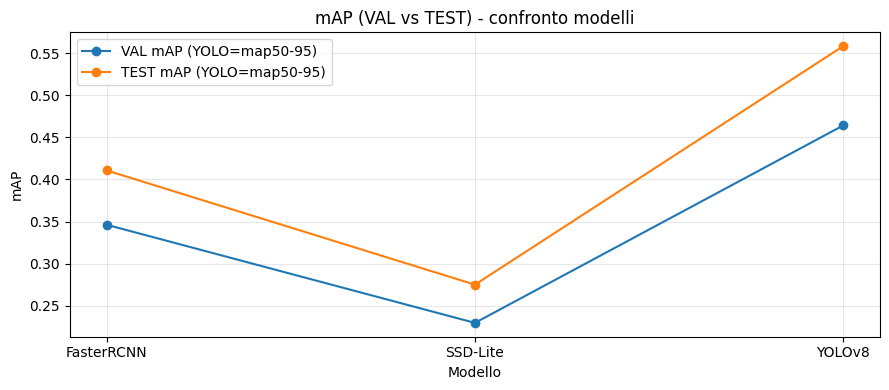


✅ Salvato su Drive:
 - CSV : /content/drive/MyDrive/model_compare/comparison_results.csv
 - JSON: /content/drive/MyDrive/model_compare/comparison_results.json
 - PNG : /content/drive/MyDrive/model_compare/comparison_plot.png

🔎 metrics_epoch_*.json trovati sotto model_compare:
 - /content/drive/MyDrive/model_compare/fasterrcnn_3class/metrics_epoch_02.json


In [16]:
# ============================
# DEFINITIVO: confronto FasterRCNN + SSD-Lite + YOLOv8
# - auto-scan per trovare metrics_epoch_*.json (Faster/SSD)
# - YOLO: valori INSERITI MANUALMENTE (da tua eval coerente yolo_eval_fix)
# - salva CSV + JSON + PNG su Drive
# ============================

import os, re, json, glob, time
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) PATH BASE (Drive)
# ----------------------------
BASE_COMPARE = Path("/content/drive/MyDrive/model_compare")
BASE_COMPARE.mkdir(parents=True, exist_ok=True)

OUT_CSV  = BASE_COMPARE / "comparison_results.csv"
OUT_JSON = BASE_COMPARE / "comparison_results.json"
OUT_PNG  = BASE_COMPARE / "comparison_plot.png"

# ----------------------------
# 1) UTILS: trova ultimo metrics_epoch_*.json per modello (STRICT)
# ----------------------------
def _epoch_from_name(p: Path):
    m = re.search(r"metrics_epoch_(\d+)\.json$", p.name)
    return int(m.group(1)) if m else -1

def find_latest_epoch_metrics(model_keywords, base_dir: Path, strict=True):
    """
    strict=True  -> se non trova candidati per keyword, ritorna (None,None) (NO fallback!)
    strict=False -> se non trova candidati, fallback su qualunque metrics_epoch_*.json
    """
    all_json = [Path(p) for p in glob.glob(str(base_dir / "**/metrics_epoch_*.json"), recursive=True)]
    if not all_json:
        return None, None

    kw = [k.lower() for k in model_keywords]
    candidates = [p for p in all_json if any(k in str(p.parent).lower() or k in p.name.lower() for k in kw)]

    if not candidates:
        if strict:
            return None, None
        candidates = all_json

    candidates = sorted(candidates, key=lambda p: (_epoch_from_name(p), p.stat().st_mtime))
    best = candidates[-1]

    d = json.load(open(best))
    out = {
        "loss": d.get("loss", None),
        "val_map":  d.get("valid", {}).get("metrics", {}).get("map", None),
        "val_map50": d.get("valid", {}).get("metrics", {}).get("map_50", None),
        "test_map": d.get("test", {}).get("metrics", {}).get("map", None),
        "test_map50": d.get("test", {}).get("metrics", {}).get("map_50", None),
        "source": str(best)
    }
    return out, best

def sf(x):
    try:
        return float(x) if x is not None else None
    except Exception:
        return None

# ----------------------------
# 2) Faster + SSD: lettura automatica (SSD STRICT) + fallback manuale opzionale
# ----------------------------
rows = []

# Faster: posso lasciare strict=False (se vuoi), ma qui lo metto strict=True per coerenza
f_metrics, _ = find_latest_epoch_metrics(["faster", "fasterrcnn"], BASE_COMPARE, strict=True)
rows.append({
    "model": "FasterRCNN",
    "val_map": sf(f_metrics["val_map"]) if f_metrics else None,
    "val_map50": sf(f_metrics["val_map50"]) if f_metrics else None,
    "test_map": sf(f_metrics["test_map"]) if f_metrics else None,
    "test_map50": sf(f_metrics["test_map50"]) if f_metrics else None,
    "loss": sf(f_metrics["loss"]) if f_metrics else None,
    "source": f_metrics["source"] if f_metrics else "NOT FOUND (no Faster metrics_epoch_*.json)"
})

# SSD: STRICT=True così NON prende mai file di Faster
s_metrics, _ = find_latest_epoch_metrics(["ssdlite_3class", "ssdlite", "ssd_lite", "ssd-lite", "ssd_3class"], BASE_COMPARE, strict=True)

# (OPZIONALE) fallback manuale SSD se non trovi metrics_epoch_*.json
SSD_MANUAL_FALLBACK = True
SSD_VAL_MAP    = 0.2297
SSD_VAL_MAP50  = 0.3779
SSD_TEST_MAP   = 0.2751
SSD_TEST_MAP50 = 0.4518
SSD_LOSS       = 1.7016

if (s_metrics is None) and SSD_MANUAL_FALLBACK:
    s_metrics = {
        "val_map": SSD_VAL_MAP,
        "val_map50": SSD_VAL_MAP50,
        "test_map": SSD_TEST_MAP,
        "test_map50": SSD_TEST_MAP50,
        "loss": SSD_LOSS,
        "source": "MANUAL (SSD values inserted)"
    }

rows.append({
    "model": "SSD-Lite",
    "val_map": sf(s_metrics["val_map"]) if s_metrics else None,
    "val_map50": sf(s_metrics["val_map50"]) if s_metrics else None,
    "test_map": sf(s_metrics["test_map"]) if s_metrics else None,
    "test_map50": sf(s_metrics["test_map50"]) if s_metrics else None,
    "loss": sf(s_metrics["loss"]) if s_metrics else None,
    "source": s_metrics["source"] if s_metrics else "NOT FOUND (no SSD metrics_epoch_*.json)"
})
# ----------------------------
# 3) YOLO: valori MANUALI (da tua eval coerente)
# ----------------------------
YOLO_VAL_MAP   = 0.46415632073135077
YOLO_VAL_MAP50 = 0.5758103186959325
YOLO_TEST_MAP  = 0.5583108004809518
YOLO_TEST_MAP50= 0.6999588990618928

rows.append({
    "model": "YOLOv8",
    "val_map": YOLO_VAL_MAP,
    "val_map50": YOLO_VAL_MAP50,
    "test_map": YOLO_TEST_MAP,
    "test_map50": YOLO_TEST_MAP50,
    "loss": None,
    "source": "MANUAL (yolo_eval_fix: YAML coerente con best.pt)"
})

# ----------------------------
# 4) DataFrame + BEST MODEL
# ----------------------------
df = pd.DataFrame(rows)

# score: priorità test_map se presente, altrimenti val_map
df["score"] = df.apply(lambda r: r["test_map"] if pd.notna(r["test_map"]) else r["val_map"], axis=1)

best_model = "N/A"
if df["score"].notna().any():
    best_model = df.loc[df["score"].astype("float64").idxmax(), "model"]

print("\n====================")
print("RISULTATI (VAL / TEST)")
print("====================\n")
print(df[["model","val_map","val_map50","test_map","test_map50","loss","source"]].to_string(index=False))
print("\n🏆 Migliore (priorità TEST mAP, altrimenti VAL mAP):", best_model)

# ----------------------------
# 5) GRAFICO (e salvataggio PNG su Drive)
# ----------------------------
plt.figure(figsize=(9,4))
plt.plot(df["model"], df["val_map"], marker="o", label="VAL mAP (YOLO=map50-95)")
plt.plot(df["model"], df["test_map"], marker="o", label="TEST mAP (YOLO=map50-95)")
plt.title("mAP (VAL vs TEST) - confronto modelli")
plt.xlabel("Modello")
plt.ylabel("mAP")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.show()

# ----------------------------
# 6) SALVATAGGI FINALI su Drive
# ----------------------------
df.to_csv(OUT_CSV, index=False)
with open(OUT_JSON, "w") as f:
    json.dump(
        {"rows": rows, "best_model": best_model, "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")},
        f, indent=2
    )

print("\n✅ Salvato su Drive:")
print(" - CSV :", OUT_CSV)
print(" - JSON:", OUT_JSON)
print(" - PNG :", OUT_PNG)

# Debug utile: mostra i metrics_epoch trovati
all_found = sorted(glob.glob(str(BASE_COMPARE / "**/metrics_epoch_*.json"), recursive=True))
print("\n🔎 metrics_epoch_*.json trovati sotto model_compare:")
for p in all_found[:80]:
    print(" -", p)
if len(all_found) > 80:
    print(" ... (altri", len(all_found)-80, "file)")

In [3]:
!find /content/drive/MyDrive -name "best.pt"

/content/drive/MyDrive/yolo_runs/ppe_yolov8n_10ep/weights/best.pt
/content/drive/MyDrive/yolo_runs/ppe_3class_10ep/weights/best.pt
/content/drive/MyDrive/yolo_runs/ppe_3class_plus20/weights/best.pt
/content/drive/MyDrive/yolo_runs/ppe_3class_yolov8s/weights/best.pt
/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt


In [4]:
!pip install -q ultralytics

from ultralytics import YOLO

MODEL_PATH = "/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt"

model = YOLO(MODEL_PATH)

model.predict(
    source="/content/drive/MyDrive/DPI_PROJECT_DPI3/test/images",
    save=True,
    conf=0.25
)


image 1/392 /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000009_jpg.rf.f28f4bf1694695de0592898a09a7a536.jpg: 384x640 2 safety_vests, 67.7ms
image 2/392 /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000028_jpg.rf.efea3f07920d1141570facc74bcc109f.jpg: 384x640 6 safety_vests, 6.7ms
image 3/392 /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000033_jpg.rf.2b81269c3acc45bd1e4e96da19f45239.jpg: 384x640 (no detections), 6.8ms
image 4/392 /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000038_jpg.rf.ad04ed97115675256e2c2b98e95facc9.jpg: 384x640 (no detections), 10.9ms
image 5/392 /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000039_jpg.rf.907eafa889d8433aa8fbfbba384c1351.jpg: 384x640 1 safety_vest, 8.9ms
image 6/392 /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000040_jpg.rf.35dec706feeb65b830a77e0a4bdb8c6f.jpg: 384x640 1 safety_vest, 12.6ms
image 7/392 /content/drive/MyDrive/DPI_PROJECT_DPI3/test/images/00000053_jpg.rf.a86015752323ab1cd43f0a7f0bce

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'safety_vest', 1: 'gloves', 2: 'safety_shoes'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [109, 134, 206],
         [112, 137, 209],
         [105, 130, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 133, 205],
         [110, 135, 207],
         [105, 130, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 136, 207],
         [110, 138, 209],
         [106, 134, 205]],
 
        ...,
 
        [[ 83,  85,  96],
         [ 84,  86,  97],
         [ 83,  85,  96],
         ...,
         [141, 124, 168],
         [141, 124, 168],
         [141, 124, 168]],
 
        [[ 84,  86,  97],
         [ 86,  88,  99],
         [ 85,  87,  

In [13]:
# ============================
# FIX COERENZA YOLO: crea mini-dataset (VAL+TEST) coerente con best.pt (vest/gloves/shoes)
# - copia images+labels di val/test
# - rimappa classi: Gloves(0)->gloves(1), SafetyBoot(1)->safety_shoes(2), SafetyVest(2)->safety_vest(0)
# - crea data.yaml coerente e lancia model.val() su val e test
# ============================

import os, shutil, glob, yaml
from pathlib import Path

# --- INPUT (TUOI PATH) ---
MODEL = "/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt"

# dataset che hai ora (quello con Gloves/Boot/Vest)
SRC_ROOT = Path("/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS")  # <- se diverso, cambia qui

# --- OUTPUT (nuovo mini-dataset in Drive) ---
OUT_ROOT = Path("/content/drive/MyDrive/model_compare/yolo_eval_fix")  # cartella nuova
(OUT_ROOT / "val/images").mkdir(parents=True, exist_ok=True)
(OUT_ROOT / "val/labels").mkdir(parents=True, exist_ok=True)
(OUT_ROOT / "test/images").mkdir(parents=True, exist_ok=True)
(OUT_ROOT / "test/labels").mkdir(parents=True, exist_ok=True)

# --- Rimappatura classi (old -> new) ---
# old yaml: [Gloves, Safety Boot, Safety Vest]
# model:    [safety_vest, gloves, safety_shoes]
REMAPPING = {0: 1, 1: 2, 2: 0}

# --- Copia immagini + conversione labels (VAL e TEST) ---
def copy_images(src_img_dir: Path, dst_img_dir: Path):
    imgs = sorted(glob.glob(str(src_img_dir / "*.*")))
    for p in imgs:
        shutil.copy2(p, dst_img_dir / Path(p).name)

def remap_labels(src_lbl_dir: Path, dst_lbl_dir: Path):
    lbls = sorted(glob.glob(str(src_lbl_dir / "*.txt")))
    for lp in lbls:
        out_lines = []
        with open(lp, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                cls = int(float(parts[0]))
                new_cls = REMAPPING.get(cls, cls)
                parts[0] = str(new_cls)
                out_lines.append(" ".join(parts))
        with open(dst_lbl_dir / Path(lp).name, "w") as g:
            g.write("\n".join(out_lines) + ("\n" if out_lines else ""))

# path sorgenti
SRC_VAL_IMG = SRC_ROOT / "valid/images"
SRC_VAL_LBL = SRC_ROOT / "valid/labels"
SRC_TST_IMG = SRC_ROOT / "test/images"
SRC_TST_LBL = SRC_ROOT / "test/labels"

print("SRC exists?", SRC_ROOT.exists())
print("VAL IMG:", SRC_VAL_IMG, "exists?", SRC_VAL_IMG.exists())
print("VAL LBL:", SRC_VAL_LBL, "exists?", SRC_VAL_LBL.exists())
print("TST IMG:", SRC_TST_IMG, "exists?", SRC_TST_IMG.exists())
print("TST LBL:", SRC_TST_LBL, "exists?", SRC_TST_LBL.exists())

# copia + remap
copy_images(SRC_VAL_IMG, OUT_ROOT / "val/images")
remap_labels(SRC_VAL_LBL, OUT_ROOT / "val/labels")

copy_images(SRC_TST_IMG, OUT_ROOT / "test/images")
remap_labels(SRC_TST_LBL, OUT_ROOT / "test/labels")

# --- Crea YAML coerente col MODEL ---
# NB: usiamo solo val/test (train non serve per valutare)
DATA_YAML = OUT_ROOT / "data.yaml"
data_dict = {
    "path": str(OUT_ROOT),
    "train": "val/images",          # placeholder, non usato qui
    "val": "val/images",
    "test": "test/images",
    "names": ["safety_vest", "gloves", "safety_shoes"],
    "nc": 3
}
with open(DATA_YAML, "w") as f:
    yaml.safe_dump(data_dict, f, sort_keys=False)

print("\n✅ Creato YAML coerente:", DATA_YAML)
print(open(DATA_YAML).read())

# --- Valutazione YOLO (VAL + TEST) ---
from ultralytics import YOLO
m = YOLO(MODEL)

print("\nMODEL classes:", m.names)

m_val = m.val(data=str(DATA_YAML), split="val", imgsz=640, device="cpu")
print("\nYOLO VAL mAP(50-95):", float(m_val.box.map))
print("YOLO VAL mAP50    :", float(m_val.box.map50))

m_test = m.val(data=str(DATA_YAML), split="test", imgsz=640, device="cpu")
print("\nYOLO TEST mAP(50-95):", float(m_test.box.map))
print("YOLO TEST mAP50    :", float(m_test.box.map50))

print("\n📁 Output dataset eval:", OUT_ROOT)

SRC exists? True
VAL IMG: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/valid/images exists? True
VAL LBL: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/valid/labels exists? True
TST IMG: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images exists? True
TST LBL: /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/labels exists? True

✅ Creato YAML coerente: /content/drive/MyDrive/model_compare/yolo_eval_fix/data.yaml
path: /content/drive/MyDrive/model_compare/yolo_eval_fix
train: val/images
val: val/images
test: test/images
names:
- safety_vest
- gloves
- safety_shoes
nc: 3


MODEL classes: {0: 'safety_vest', 1: 'gloves', 2: 'safety_shoes'}
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.9±0.4 ms, read: 21.1±5.7 MB/s, size: 41.2 KB)
val: Scanning /content/drive/MyDrive/model_compare/yolo_eval_fix/val/labels... 851 images, 359 bac

In [14]:
from ultralytics import YOLO

MODEL = "/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt"
DATA  = "/content/drive/MyDrive/model_compare/yolo_eval_fix/data.yaml"  # The correct absolute path

model = YOLO(MODEL)

metrics = model.val(
    data=DATA,
    split="test",
    conf=0.25,
    iou=0.5,
    plots=True
)

print("Class order:", model.names)
print("mAP@50-95 per classe:", metrics.box.maps)
print("Precision media:", metrics.box.mp)
print("Recall medio:", metrics.box.mr)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.1±1.0 ms, read: 17.2±8.5 MB/s, size: 61.3 KB)
val: Scanning /content/drive/MyDrive/model_compare/yolo_eval_fix/test/labels.cache... 392 images, 146 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 392/392 86.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 4.1it/s 6.1s
                   all        392        780      0.577      0.911       0.69      0.572
           safety_vest        231        292      0.636      0.965      0.818      0.753
                gloves         73        132      0.367      0.781      0.463      0.319
          safety_shoes        175        356      0.728      0.986      0.788      0.644
Speed: 2.0ms preprocess, 4.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/

In [18]:
model.predict(
    source="/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images",
    save=True,
    conf=0.25,
    name="DPI3_test_preds"
)


image 1/392 /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images/00000009_jpg.rf.f28f4bf1694695de0592898a09a7a536.jpg: 384x640 2 safety_vests, 7.1ms
image 2/392 /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images/00000028_jpg.rf.efea3f07920d1141570facc74bcc109f.jpg: 384x640 6 safety_vests, 6.1ms
image 3/392 /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images/00000033_jpg.rf.2b81269c3acc45bd1e4e96da19f45239.jpg: 384x640 (no detections), 5.7ms
image 4/392 /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images/00000038_jpg.rf.ad04ed97115675256e2c2b98e95facc9.jpg: 384x640 (no detections), 24.8ms
image 5/392 /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images/00000039_jpg.rf.907eafa889d8433aa8fbfbba384c1351.jpg: 384x640 1 safety_vest, 7.7ms
image 6/392 /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images/00000040_jpg.rf.35dec706feeb65b830a77e0a4bdb8c6f.jpg: 384x640 1 safety_vest, 7.8ms
image 7/392 /content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/imag

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'safety_vest', 1: 'gloves', 2: 'safety_shoes'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [109, 134, 206],
         [112, 137, 209],
         [105, 130, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 133, 205],
         [110, 135, 207],
         [105, 130, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 136, 207],
         [110, 138, 209],
         [106, 134, 205]],
 
        ...,
 
        [[ 83,  85,  96],
         [ 84,  86,  97],
         [ 83,  85,  96],
         ...,
         [141, 124, 168],
         [141, 124, 168],
         [141, 124, 168]],
 
        [[ 84,  86,  97],
         [ 86,  88,  99],
         [ 85,  87,  

Results saved to /content/runs/detect/predict3
RILEVATI: {'safety_vest'}
MANCANTI: {'gloves', 'safety_shoes'}
CONFORME: False


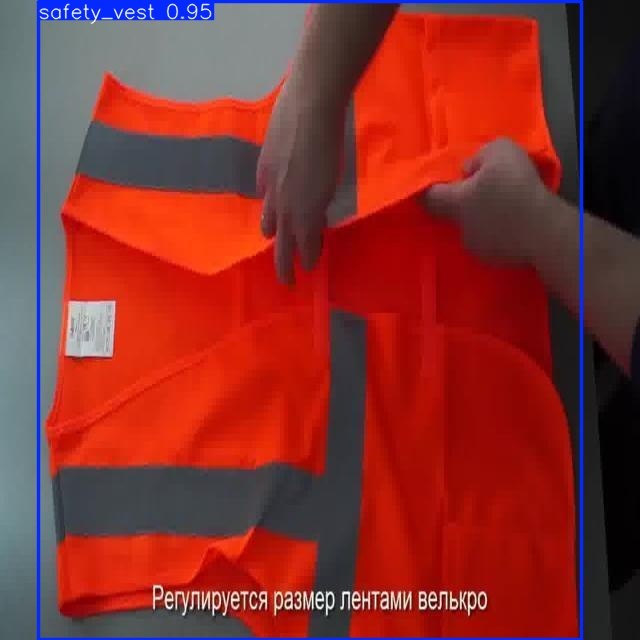

In [20]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import display, Image

# Carica modello
model = YOLO("/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt")

REQUIRED_DPI = {"safety_vest", "gloves", "safety_shoes"}

def check_and_show(image_path, conf=0.25):
    results = model.predict(source=image_path, conf=conf, save=True, verbose=False)
    r = results[0]

    detected = set()
    for cls_id in r.boxes.cls.tolist():
        detected.add(r.names[int(cls_id)])

    missing = REQUIRED_DPI - detected
    compliant = len(missing) == 0

    print("RILEVATI:", detected)
    print("MANCANTI:", missing)
    print("CONFORME:", compliant)

    # Mostra immagine salvata
    display(Image(filename=r.save_dir + "/" + Path(image_path).name))

# prova su un'immagine di test
sample_img = next(Path("/content/drive/MyDrive/DPI_PROJECT_DPI3_3CLASS/test/images").glob("*"))
check_and_show(str(sample_img))


In [21]:
import shutil
from pathlib import Path

src_root = Path("Construction-PPE-1")
dst_root = Path("Construction-PPE-1_DPI3")
splits = ["train", "valid", "test"]

keep_classes = {
    4: 0,   # Safety Vest
    15: 0,  # vest
    0: 1,   # Gloves
    7: 1,   # gloves
    3: 2,   # Safety Boot
    5: 2    # boots
}

def find_image_file(img_dir: Path, stem: str):
    for ext in [".jpg", ".jpeg", ".png", ".webp"]:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None

if dst_root.exists():
    shutil.rmtree(dst_root)
dst_root.mkdir(parents=True, exist_ok=True)

for split in splits:
    (dst_root / split / "images").mkdir(parents=True, exist_ok=True)
    (dst_root / split / "labels").mkdir(parents=True, exist_ok=True)

    src_img_dir = src_root / split / "images"
    src_lbl_dir = src_root / split / "labels"
    dst_img_dir = dst_root / split / "images"
    dst_lbl_dir = dst_root / split / "labels"

    for label_path in src_lbl_dir.glob("*.txt"):
        stem = label_path.stem
        new_lines = []
        for line in label_path.read_text().strip().splitlines():
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            old_cls = int(float(parts[0]))
            if old_cls in keep_classes:
                parts[0] = str(keep_classes[old_cls])
                new_lines.append(" ".join(parts))

        if new_lines:
            img_path = find_image_file(src_img_dir, stem)
            if img_path is None:
                continue
            shutil.copy(img_path, dst_img_dir / img_path.name)
            (dst_lbl_dir / f"{stem}.txt").write_text("\n".join(new_lines))

data_yaml = f"""path: {dst_root}
train: train/images
val: valid/images
test: test/images

names:
  0: safety_vest
  1: gloves
  2: safety_shoes
"""
(dst_root / "data.yaml").write_text(data_yaml)
print("✅ DPI3 pronto:", dst_root)

✅ DPI3 pronto: Construction-PPE-1_DPI3


In [22]:
import json

CLASS_MAP = {0: "safety_vest", 1: "gloves", 2: "safety_shoes"}
REQUIRED = {"safety_vest", "gloves", "safety_shoes"}

def compliance_engine(image_path, conf=0.25):
    r = model.predict(source=image_path, conf=conf, verbose=False)[0]

    detected = set()
    conf_by_class = {}

    if r.boxes is not None and len(r.boxes) > 0:
        for cls_id, score in zip(r.boxes.cls.tolist(), r.boxes.conf.tolist()):
            cls_name = CLASS_MAP[int(cls_id)]
            detected.add(cls_name)
            conf_by_class[cls_name] = max(conf_by_class.get(cls_name, 0.0), float(score))

    missing = sorted(list(REQUIRED - detected))
    detected = sorted(list(detected))

    if len(missing) == 0:
        status = "CONFORME"
    elif len(missing) == 1:
        status = "PARZIALMENTE_CONFORME"
    else:
        status = "NON_CONFORME"

    return {
        "image": image_path,
        "status": status,
        "detected": detected,
        "missing": missing,
        "confidence_by_class": conf_by_class
    }

In [24]:
from pathlib import Path
sample_img = next(Path("/content/drive/MyDrive/model_compare/yolo_eval_fix/test/images").glob("*"))

out = compliance_engine(str(sample_img), conf=0.25)
print(json.dumps(out, indent=2))

{
  "image": "/content/drive/MyDrive/model_compare/yolo_eval_fix/test/images/00000009_jpg.rf.f28f4bf1694695de0592898a09a7a536.jpg",
  "status": "NON_CONFORME",
  "detected": [
    "safety_vest"
  ],
  "missing": [
    "gloves",
    "safety_shoes"
  ],
  "confidence_by_class": {
    "safety_vest": 0.4535847008228302
  }
}


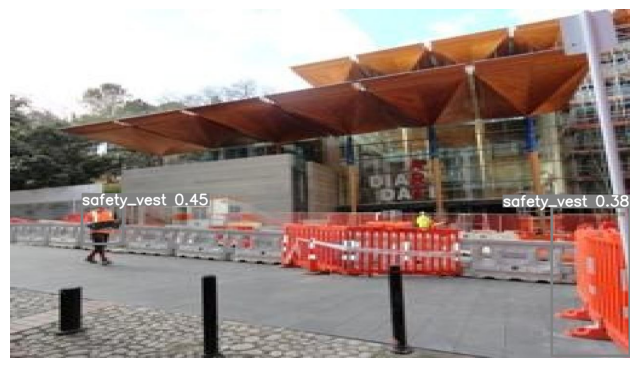

In [25]:
from ultralytics.utils.plotting import Annotator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def show_prediction(image_path, conf=0.25):
    r = model.predict(source=image_path, conf=conf, verbose=False)[0]
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    annotator = Annotator(img_np.copy())
    if r.boxes is not None and len(r.boxes) > 0:
        for box, cls_id, score in zip(r.boxes.xyxy, r.boxes.cls, r.boxes.conf):
            cls_name = CLASS_MAP[int(cls_id)]
            label = f"{cls_name} {float(score):.2f}"
            annotator.box_label(box.tolist(), label)
    out_img = annotator.result()

    plt.figure(figsize=(8,6))
    plt.imshow(out_img)
    plt.axis("off")
    plt.show()

show_prediction(str(sample_img), conf=0.25)

In [78]:
from ultralytics import YOLO
from pathlib import Path
from collections import Counter
import pandas as pd
import random
import time

# =========================
# CONFIG
# =========================
MODEL_PATH = "/content/drive/MyDrive/DPI_PROJECT_FINAL/runs/YOLOv8n_DPI3/weights/best.pt"
IMAGES_DIR = "/content/drive/MyDrive/model_compare/yolo_eval_fix/test/images"  # cambia se vuoi val/images
OUT_CSV    = "/content/drive/MyDrive/model_compare/yolo_eval_fix/kpi_results_testset.csv"

CONF  = 0.25
IMGSZ = 960
N_MAX = 200

# Classi attese (per KPI)
REQUIRED = {"safety_vest", "gloves", "safety_shoes"}

# =========================
# KPI RULES
# =========================
def classify_compliance(present: set) -> str:
    missing = REQUIRED - present
    # conforme: tutto presente
    if not missing:
        return "CONFORME"
    # parzialmente: mancano SOLO i guanti
    if missing == {"gloves"}:
        return "PARZIALMENTE_CONFORME"
    # tutto il resto = non conforme
    return "NON_CONFORME"

def safety_index(status_counts: Counter) -> float:
    """
    Safety Index semplice:
    1.0 per CONFORME
    0.5 per PARZIALMENTE_CONFORME
    0.0 per NON_CONFORME
    normalizzato su totale
    """
    total = sum(status_counts.values()) if status_counts else 0
    if total == 0:
        return 0.0
    score = (
        1.0 * status_counts.get("CONFORME", 0)
        + 0.5 * status_counts.get("PARZIALMENTE_CONFORME", 0)
        + 0.0 * status_counts.get("NON_CONFORME", 0)
    )
    return score / total

# =========================
# RUN KPI BATCH
# =========================
def run_batch_kpi(images_dir=IMAGES_DIR, model_path=MODEL_PATH, n=N_MAX, conf=CONF, imgsz=IMGSZ, seed=42):
    images_dir = Path(images_dir)
    assert images_dir.exists(), f"Cartella immagini non trovata: {images_dir}"

    m = YOLO(model_path)
    print("MODEL names:", m.names)  # debug rapido

    imgs = [p for p in images_dir.glob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".webp"]]
    if not imgs:
        raise RuntimeError(f"Nessuna immagine trovata in: {images_dir}")

    random.seed(seed)
    if n and n < len(imgs):
        imgs = random.sample(imgs, n)

    rows = []
    status_c = Counter()
    missing_c = Counter()

    t0 = time.time()
    for p in imgs:
        res = m.predict(source=str(p), conf=conf, imgsz=imgsz, verbose=False)
        r = res[0]

        # classi rilevate
        detected_counts = Counter()
        present = set()

        if r.boxes is not None and len(r.boxes) > 0:
            cls_ids = r.boxes.cls.tolist()
            for cid in cls_ids:
                name = m.names[int(cid)]
                detected_counts[name] += 1
                present.add(name)

        status = classify_compliance(present)
        missing = sorted(list(REQUIRED - present))

        status_c[status] += 1
        for x in missing:
            missing_c[x] += 1

        rows.append({
            "image": str(p),
            "status": status,
            "missing": ",".join(missing),
            "present": ",".join(sorted(list(present))),
            "detected_counts": dict(detected_counts),
            "n_vest": int(detected_counts.get("safety_vest", 0)),
            "n_gloves": int(detected_counts.get("gloves", 0)),
            "n_shoes": int(detected_counts.get("safety_shoes", 0)),
            "conf": conf,
            "imgsz": imgsz
        })

    df = pd.DataFrame(rows)
    si = safety_index(status_c)

    print("\nStatus counts:", status_c)
    print("Missing counts:", missing_c)
    print(f"✅ Safety Index: {si:.3f}  (1=top, 0=scarso)")
    print(f"Tempo batch: {time.time()-t0:.1f}s | N={len(df)}")

    # salva CSV
    Path(OUT_CSV).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(OUT_CSV, index=False)
    print("✅ Salvato CSV:", OUT_CSV)

    return df, status_c, missing_c, si

# ESECUZIONE
df_kpi, status_c, missing_c, safety_idx = run_batch_kpi()
df_kpi.head(10)

MODEL names: {0: 'safety_vest', 1: 'gloves', 2: 'safety_shoes'}

Status counts: Counter({'CONFORME': 100, 'NON_CONFORME': 86, 'PARZIALMENTE_CONFORME': 14})
Missing counts: Counter({'gloves': 90, 'safety_shoes': 80, 'safety_vest': 25})
✅ Safety Index: 0.535  (1=top, 0=scarso)
Tempo batch: 5.0s | N=200
✅ Salvato CSV: /content/drive/MyDrive/model_compare/yolo_eval_fix/kpi_results_testset.csv


,image,status,missing,present,detected_counts,n_vest,n_gloves,n_shoes,conf,imgsz
0,/content/drive/MyDrive/model_compare/yolo_eval...,CONFORME,,"gloves,safety_shoes,safety_vest","{'safety_vest': 1, 'safety_shoes': 2, 'gloves'...",1,2,2,0.25,960
1,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,"gloves,safety_shoes",safety_vest,{'safety_vest': 1},1,0,0,0.25,960
2,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,"gloves,safety_shoes",safety_vest,{'safety_vest': 5},5,0,0,0.25,960
3,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,"gloves,safety_shoes",safety_vest,{'safety_vest': 2},2,0,0,0.25,960
4,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,"gloves,safety_shoes",safety_vest,{'safety_vest': 1},1,0,0,0.25,960
5,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,"gloves,safety_shoes",safety_vest,{'safety_vest': 2},2,0,0,0.25,960
6,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,"gloves,safety_shoes",safety_vest,{'safety_vest': 1},1,0,0,0.25,960
7,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,"gloves,safety_shoes,safety_vest",,{},0,0,0,0.25,960
8,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,"gloves,safety_shoes",safety_vest,{'safety_vest': 3},3,0,0,0.25,960
9,/content/drive/MyDrive/model_compare/yolo_eval...,NON_CONFORME,safety_vest,"gloves,safety_shoes","{'safety_shoes': 2, 'gloves': 1}",0,1,2,0.25,960
